In [ ]:
# Modeling nuclear binding energies with an extended semiempirical mass formula

# First fit starts with the basic formula to determine the classical coefficients
# and the baseline rms error and then the coefficients are expanded in terms of 
# proton and neutron numbers

In [1]:
%matplotlib inline 

import numpy as np
import itertools
import matplotlib.pyplot as plt
import csv
import random

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def rmserror(predicted, exp):
    return np.sqrt(np.sum(np.power(predicted-exp,2)/predicted.size))

def oddeven(nneu,npro):
    if(nneu % 2 == 0 and npro % 2 == 0):
        return 1
    elif (nneu % 2 == 1 and npro % 2 == 1):
        return -1
    else:
        return 0

def sheff(nneu,npro):
    shells = [184,126,82,50,28,20,8,2]
    nnvalence = nneu - next((x for x in shells if x <= nneu))
    npvalence = npro - next((x for x in shells if x <= npro))
    if(nnvalence == 0) and (npvalence == 0):
        return 0
    else:
        return nnvalence*npvalence/(nnvalence + npvalence)

def random_combination(iterable, r):
# Random selection from itertools.combinations(iterable,r)    
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n),r))
    return tuple(pool[i] for i in indices)

In [3]:
tick_font_size = 14
eps = 1e-3

In [4]:
# read data and transform
data_raw = np.genfromtxt("data.dat",usecols = (0,1,2,5), unpack = True).transpose()
nproton = data_raw[:,1]
nmass = data_raw[:,0]
nneutron = nmass - nproton
ndiff = nneutron - nproton
beta2 = data_raw[:,2]

# odd or even nuclei
oddeven_eff = np.zeros(nmass.shape)
for a in range(len(nmass)):
    oddeven_eff[a] = oddeven(nneutron[a],nproton[a])

# shell effects
shell_eff = np.zeros(nmass.shape)
for a in range(len(nmass)):
    shell_eff[a] = sheff(nneutron[a],nproton[a])
    
# measurements
data_y = -data_raw[:,3]

In [5]:
# First only use the linear term in nuclear mass
data_x = nmass

regr = linear_model.LinearRegression(fit_intercept = False)
regr.fit(data_x.reshape(-1,1),data_y)
data_y_th = regr.predict(data_x.reshape(-1,1))

print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ",rmserror(data_y_th,data_y))

Coefficients:  [ 7.95257505]
rms error [MeV]:  48.7144220204


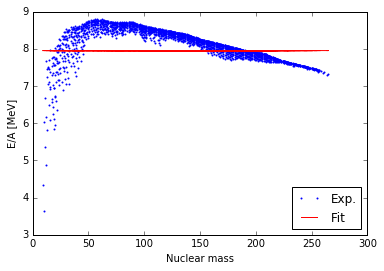

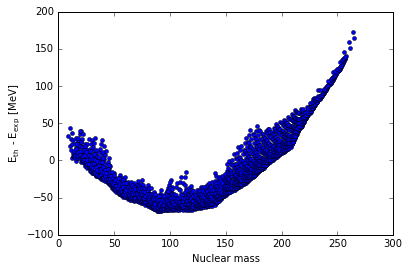

In [6]:
# Figures for the first fit
plt.figure(1)
plt.plot(nmass,data_y/nmass,'bo', markersize = 2, markeredgewidth = 0.0)
plt.plot(nmass,data_y_th/nmass,'r-')
plt.xlabel("Nuclear mass")
plt.ylabel("E/A [MeV]")
plt.legend(("Exp.","Fit"),loc = "lower right")
plt.show(1)

plt.figure(2)
plt.plot(nmass,(data_y_th - data_y),'bo', markersize = 4)
plt.xlabel("Nuclear mass")
plt.ylabel('$\mathregular{E_{th}}$ - $\mathregular{E_{exp}}$ [MeV]')
plt.show(2)

Fit to a single parameter produces a constant binding energy for all nuclei. This only describes the basic, bulk behavior of the binding energy, but is a good start. It produces a lot of overbinding in heavy nuclei due to neglected terms. 

In [7]:
# Adding the surface term, proportional to A^{2/3}
surf = np.power(nmass,2.0/3.0)
data_x = np.column_stack([nmass, surf])

regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)

print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ",rmserror(data_y_th,data_y))

Coefficients:  [  5.62341266  12.92433609]
rms error [MeV]:  27.2984297859


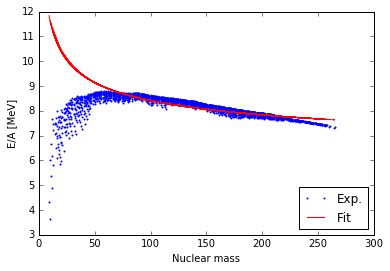

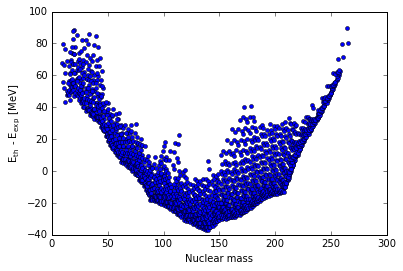

In [8]:
# Figures for the second fit
plt.figure(3)
plt.plot(nmass,data_y/nmass,'bo',markersize = 2, markeredgewidth = 0.0)
plt.plot(nmass,data_y_th/nmass,'r-')
plt.xlabel("Nuclear mass")
plt.ylabel("E/A [MeV]")
plt.legend(("Exp.","Fit"),loc = "lower right")
plt.show(3)

plt.figure(4)
plt.plot(nmass,(data_y_th - data_y),'bo', markersize = 4)
plt.xlabel("Nuclear mass")
plt.ylabel('$\mathregular{E_{th}}$ - $\mathregular{E_{exp}}$ [MeV]')
plt.show(4)

As the first correction to the volume term, the surface term is included proportional to $A^{2/3}$. In the simple liquid drop picture, it describes the nuclei at the surface which do not feel the same force from all directions. Overbinding in heavy nuclei is now much better, but it became even more pronounced in light nuclei.

In [9]:
# Adding the Coulomb term
coul = np.power(nproton,2.0)*np.power(nmass,-1.0/3.0)
data_x = np.column_stack([nmass, surf, coul])

regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)

print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y))

Coefficients:  [ 7.51872516  7.36201717 -0.16488003]
rms error [MeV]:  24.6843340771


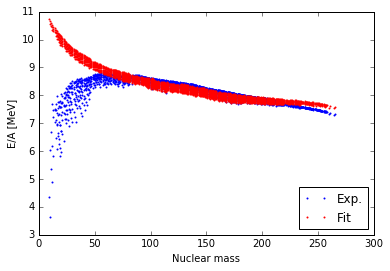

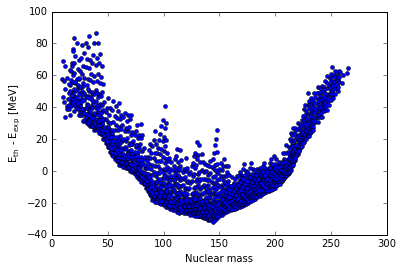

In [10]:
# Figures for the third fit
plt.figure(5)
plt.plot(nmass,data_y/nmass,'bo', markersize = 2, markeredgewidth = 0.0)
plt.plot(nmass,data_y_th/nmass,'ro', markersize = 2, markeredgewidth = 0.0)
plt.xlabel("Nuclear mass")
plt.ylabel("E/A [MeV]")
plt.legend(("Exp.","Fit"),loc = "lower right")
plt.show(5)

plt.figure(6)
plt.plot(nmass,(data_y_th - data_y),'bo', markersize = 4)
plt.xlabel("Nuclear mass")
plt.ylabel('$\mathregular{E_{th}}$ - $\mathregular{E_{exp}}$ [MeV]')
plt.show(6)

In [11]:
# Including the asymmetry term
asym = np.power(nmass - 2*nproton,2.0)/nmass
data_x = np.column_stack([nmass, surf, coul, asym])

regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)

print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y))

Coefficients:  [ 15.53037403 -16.94523239  -0.70161639 -22.94549678]
rms error [MeV]:  3.14449713028


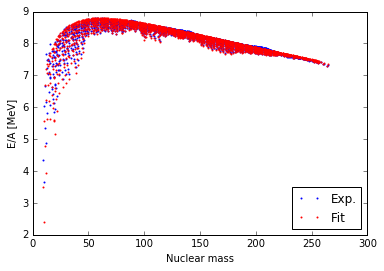

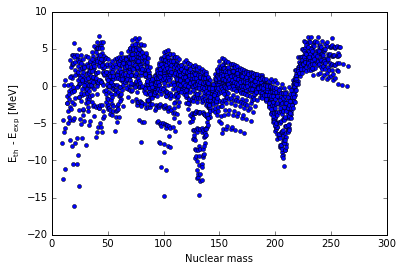

In [12]:
# Figures for the fourth fit
plt.figure(7)
plt.plot(nmass,data_y/nmass,'bo', markersize = 2, markeredgewidth = 0.0)
plt.plot(nmass,data_y_th/nmass,'ro', markersize = 2, markeredgewidth = 0.0)
plt.xlabel("Nuclear mass")
plt.ylabel("E/A [MeV]")
plt.legend(("Exp.","Fit"),loc = "lower right")
plt.show(7)

plt.figure(8)
plt.plot(nmass,(data_y_th - data_y),'bo', markersize = 4)
plt.xlabel("Nuclear mass")
plt.ylabel('$\mathregular{E_{th}}$ - $\mathregular{E_{exp}}$ [MeV]')
plt.show(8)

This already looks quite reasonable, now we try to add the pairing term. There is some freedom available here as different papers use different dependence on A. We will try several versions:
- no dependance on A
- $A^{-1/3}$
- $A^{-1/2}$
- $A^{-3/4}$
- $A^{-1}$

In [13]:
ver1 = oddeven_eff
ver2 = oddeven_eff/np.power(nmass,1.0/3.0)
ver3 = oddeven_eff/np.power(nmass,1.0/2.0)
ver4 = oddeven_eff/np.power(nmass,3.0/4.0)
ver5 = oddeven_eff/nmass

data_x = np.column_stack([nmass, surf, coul, asym, ver1])
regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)
print("No mass dependance: ")
print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y),"\n")

data_x = np.column_stack([nmass, surf, coul, asym, ver2])
regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)
print("A^{-1/3}: ")
print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y),"\n")

data_x = np.column_stack([nmass, surf, coul, asym, ver3])
regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)
print("A^{-1/2}: ")
print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y),"\n")

data_x = np.column_stack([nmass, surf, coul, asym, ver4])
regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)
print("A^{-3/4}: ")
print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y),"\n")

data_x = np.column_stack([nmass, surf, coul, asym, ver5])
regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)
print("A^{-1}: ")
print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y),"\n")

No mass dependance: 
Coefficients:  [ 15.54917127 -17.00168335  -0.70308205 -22.97711756   1.27256847]
rms error [MeV]:  3.01336397806 

A^{-1/3}: 
Coefficients:  [ 15.55078553 -17.00795532  -0.70314145 -22.98078612   6.08298208]
rms error [MeV]:  3.0022598712 

A^{-1/2}: 
Coefficients:  [ 15.55108963 -17.00954117  -0.70312945 -22.98228012  12.32856735]
rms error [MeV]:  3.00401596408 

A^{-3/4}: 
Coefficients:  [ 15.55038872 -17.0081407   -0.70303201 -22.9827884   31.58063593]
rms error [MeV]:  3.01812083857 

A^{-1}: 
Coefficients:  [ 15.54830773 -17.00208648  -0.70285133 -22.98055734  70.09494338]
rms error [MeV]:  3.04181955244 



All terms reduce the total rms error by approx. 0.1 Mev, with the best fit provided by $A^{-1/3}$ and $A^{-1/2}$ dependence. With this choice we get the standard coefficients of the semiempirical mass formula.

Coefficients:  [ 15.55108963 -17.00954117  -0.70312945 -22.98228012  12.32856735]
rms error [MeV]:  3.00401596408 



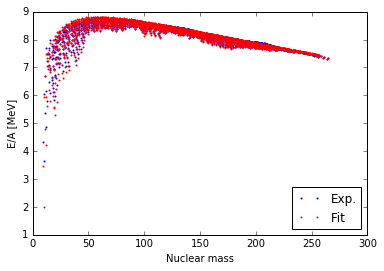

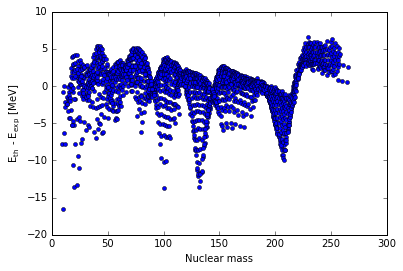

In [14]:
pairing = oddeven_eff/np.power(nmass,1.0/2.0)

data_x = np.column_stack([nmass, surf, coul, asym, pairing])
regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)

print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y),"\n")

# Figures for the fifth fit
plt.figure(9)
plt.plot(nmass,data_y/nmass,'bo', markersize = 2, markeredgewidth = 0.0)
plt.plot(nmass,data_y_th/nmass,'ro', markersize = 2, markeredgewidth = 0.0)
plt.xlabel("Nuclear mass")
plt.ylabel("E/A [MeV]")
plt.legend(("Exp.","Fit"),loc = "lower right")
plt.show(9)

plt.figure(9)
plt.plot(nmass,(data_y_th - data_y),'bo', markersize = 4)
plt.xlabel("Nuclear mass")
plt.ylabel('$\mathregular{E_{th}}$ - $\mathregular{E_{exp}}$ [MeV]')
plt.show(9)

In the lower plot, there is some regularity to the differences between the fit and the experimental values. These arcs in the plot correspond to nuclei in between closed shells. It is easier to see if the differences are plotted versus the atomic number and number of neutrons.

In particular, in the plot versus the neutron number the differences are very small for nuclei with closed neutron shell, but large between closed shells. This is the motivation for introducing the shell effects.

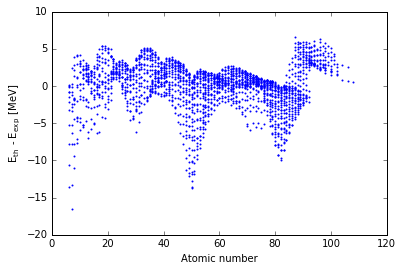

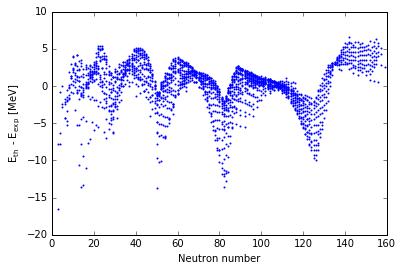

In [15]:
# Figures for the fifth fit
plt.figure(10)
plt.plot(nproton,(data_y_th - data_y),'bo', markersize = 2, markeredgewidth = 0.0)
plt.xlabel("Atomic number")
plt.ylabel('$\mathregular{E_{th}}$ - $\mathregular{E_{exp}}$ [MeV]')
plt.show(10)

plt.figure(11)
plt.plot(nneutron,(data_y_th - data_y),'bo', markersize = 2, markeredgewidth = 0.0)
plt.xlabel("Neutron number")
plt.ylabel('$\mathregular{E_{th}}$ - $\mathregular{E_{exp}}$ [MeV]')
plt.show(11)

In [16]:
data_x = np.column_stack([nmass, surf, coul, asym, pairing, shell_eff])

regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)

print("Coefficients: ",regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y),"\n")

Coefficients:  [ 15.57128423 -17.04602172  -0.70454189 -23.02423242  12.02615171
  -0.12678866]
rms error [MeV]:  2.96923474851 



In [17]:
nmass_def = np.column_stack([nmass, nmass*beta2])
surf_def = np.column_stack([surf, surf*beta2])
coul_def = np.column_stack([coul, coul*beta2])
asym_def = np.column_stack([asym, asym*beta2])

data_x = np.column_stack([nmass_def, surf_def, coul_def, asym_def, pairing, shell_eff])

regr.fit(data_x,data_y)
data_y_th = regr.predict(data_x)

print("Coefficients: ", regr.coef_)
print("rms error [MeV]: ", rmserror(data_y_th,data_y))

Coefficients:  [ 15.42176343   0.3680736  -16.71614566  -0.12247353  -0.6916669
  -0.05118044 -22.12869672  -4.58119113  12.32626372  -0.06303907]
rms error [MeV]:  2.46284675281


The parameters of the volume, surface, coulomb and asymmetry terms are expanded as:
$$a = a(1 + a_{\beta} \beta_{2})$$
where each term has its own deformation parameter. 

To reduce the number of parameters, approximations are in order:
1. $a_{surface, \beta}  = a_{volume, \beta}/3$
2. $a_{Coulomb, \beta} = 3a_{volume, \beta}$

In [ ]:
# Below this point unfinished code

In [23]:
# select starting features and create polynomial combinations
nmass_stack = np.column_stack([np.power(nmass,-0.5), np.power(nmass,-1.0/3.0), 
                               np.power(nmass,1.0/3.0), np.power(nmass,0.5)])
nprot_stack = np.column_stack([np.power(nproton,0.5), np.power(nproton,1.5)])
nneut_stack = np.column_stack([np.power(nneutron,0.5), np.power(nneutron,1.5)])
ndiff_stack = ndiff
beta2_stack = beta2
shell_stack = shell_eff
data_stack = np.column_stack([nmass_stack, nprot_stack, nneut_stack, ndiff_stack, 
                              beta2_stack, shell_stack])

features = PolynomialFeatures(2, include_bias = False, interaction_only = True)
data_x_fit = features.fit_transform(data_stack)
data_x_powers = features.powers_
print(features.n_input_features_, features.n_output_features_)

11 66


In [24]:
# filtering identical features and bias
filterlist = []
for i in range(0,data_x_fit.shape[1]-1,1):
    for j in range(i+1,data_x_fit.shape[1],1):
        if((np.allclose(data_x_fit[:,i],data_x_fit[:,j],rtol = 1e-5)) or 
           (np.allclose(data_x_fit[:,j],np.ones(data_x_fit[:,j].shape), rtol = 1e-5))):
                if j not in filterlist:
                    filterlist.append(j)

print(filterlist)
filtered_list = [item for item in range(0,data_x_fit.shape[1],1) if item not in filterlist]
print(filtered_list)
data_x_fit_filtered = data_x_fit[:,filtered_list]
data_x_powers_filtered = data_x_powers[filtered_list]

[13, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]


In [33]:
# starting linear regression
regr = linear_model.LinearRegression(fit_intercept = False)

num_features_total = data_x_fit_filtered.shape[1]
print("Total number of features: ", num_features_total)

print("\nFull fit: ")
regr.fit(data_x_fit_filtered, data_y)
data_y_fit = regr.predict(data_x_fit_filtered)
print("rms [MeV]: ", rmserror(data_y_fit,data_y))

Total number of features:  64

Full fit: 
rms [MeV]:  1.52742559069


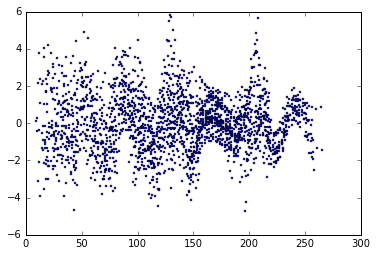

In [32]:
# plotting figure 1
plt.figure(1)
plt.plot(nmass,(data_y_fit-data_y),'bo',ms = 2)